# Task 3 - Intrusion Detection using Two-stage Ensemble Learning

Welcome to this homework - This homework implements the two-stage ensemble learning algorithms for intrusion detection that describes in the paper "Dolus: Cyber Defense using Pretense against DDoS Attacks in Cloud Platforms".

Intrusion detection is a software application or a system to detect networking malicious activity or policy violations. In this task, you will work on the open dataset "KDD Cup 1999 Data" to build a network intrusion detector, a predictive model capable of distinguishing between "bad" connections, called intrusions, attacks, or malicious, and "good" normal connections. This database contains a standard set of data to be audited, which includes a wide variety of intrusions simulated in a military network environment. 

**In this homework, you will learn how to:**
- Learn the basic concept of ensemble learning and ensemble learning implementation using XGBoost
- Learn the idea of two-stage ensemble learning for intrusion detection
- Implement the two-stage ensemble learning using XGBoost

**References**

[ICDCN18] Neupane, Roshan Lal, et al. "Dolus: cyber defense using pretense against DDoS attacks in cloud platforms." Proceedings of the 19th International Conference on Distributed Computing and Networking. 2018.(http://faculty.missouri.edu/calyamp/publications/dolus-cyber-defense-icdcn18.pdf)

[KDD2016] Chen, Tianqi, and Carlos Guestrin. "Xgboost: A scalable tree boosting system." Proceedings of the 22nd acm sigkdd international conference on knowledge discovery and data mining. 2016.

## 1 - Packages ##

let's first import all the packages that you will need during this homework.
- [python(3.8)](https://www.python.org/) 
- [numpy(1.19.1)](www.numpy.org) is the fundamental package for scientific computing with Python.
- [matplotlib(3.3.0)](http://matplotlib.org) is a library for plotting graphs in Python.
- [scikit-learn(0.23.2)](https://scikit-learn.org/) is a free software machine learning library for the Python programming language. It features various classification, regression and clustering algorithms including support vector machines, random forests, gradient boosting, k-means and DBSCAN, and is designed to interoperate with the Python numerical and scientific libraries NumPy and SciPy.
- [XGBoost(1.1.1)](https://xgboost.readthedocs.io/en/latest/) is an open-source software library which provides a gradient boosting framework for C++, Java, Python, R, Julia, Perl, and Scala.
- [pandas(1.1.0)](https://pandas.pydata.org/) is an open-source, BSD-licensed library providing high-performance, easy-to-use data structures and data analysis tools for the Python programming language.
- [seaborn(0.10.1)](https://seaborn.pydata.org/) is an open-source, statistical data visualization library

In [1]:
import numpy as np
import matplotlib
import pandas as pd 
import platform
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MultiLabelBinarizer, LabelBinarizer, LabelEncoder
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import warnings
from sklearn.model_selection import train_test_split,GridSearchCV
warnings.filterwarnings('ignore')
# if platform.system() == "Darwin":
#     matplotlib.use('TkAgg')
# else:
#     matplotlib.use('Agg')
import matplotlib.pyplot as plt
%matplotlib inline

## 2 - Explore the dataset ##

We can download the dataset from the official [websites](http://kdd.ics.uci.edu/databases/kddcup99/kddcup99.html). In this lab, we have download all the datasets and put them into kddcup_dataset/ folder. The dataset provides a full version and a $10\%$ version. But, we found the In this lab $10\%$ version is not balanced well. We provide another small version with better balanced labels to demonstrate the basic idea effectively. You can visit the KDD cup 1999 original [task descrption](http://kdd.ics.uci.edu/databases/kddcup99/task.html).

In short, the data used in this task is the networking packets collected from seven weeks of network traffic. Our task is to identify which packets are "normal" packet? and which packets are "attack" packet. If it's attack, we need to classify them into these four categories,
* DOS: denial-of-service, e.g. syn flood;
* R2L: unauthorized access from a remote machine, e.g. guessing password;
* U2R: unauthorized access to local superuser (root) privileges, e.g., various, "buffer overflow" attacks;
* probing: surveillance and other probing, e.g., port scanning.

For any machine learning question, we need to understand its features and labels. 

### 2.1 - Features

First, we can load the dataset into pandas dataframe use pandas.read_csv() interface

In [2]:
data = pd.read_csv('kddcup_dataset/kddcup.data.small', header=None)
data.head()

,0,1,2,3,4,5,6,7,8,9,...,32,33,34,35,36,37,38,39,40,41
0,0,tcp,ftp_data,REJ,0,0,0,0,0,0,...,62,0.27,0.02,0.01,0.03,0.01,0.0,0.29,0.02,portsweep.
1,1,tcp,ftp_data,RSTR,0,0,0,0,0,0,...,62,0.27,0.02,0.01,0.03,0.01,0.0,0.30,0.03,portsweep.
2,0,tcp,private,REJ,0,0,0,0,0,0,...,1,0.01,0.03,0.02,0.00,0.01,0.0,0.30,1.00,portsweep.
3,1,tcp,private,RSTR,0,0,0,0,0,0,...,2,0.01,0.03,0.02,0.00,0.01,0.0,0.30,1.00,portsweep.
4,0,tcp,private,REJ,0,0,0,0,0,0,...,1,0.01,0.03,0.03,0.00,0.01,0.0,0.31,1.00,portsweep.


As shown above, each packet has 41 features and one label ("label2") that indicates the class/type of packet. We can add the features name to the dataframe. Each feature is defined in file kddcup_dataset/kddcup.names. 

In [3]:
data.columns = [
    'duration',      # continuous, length (number of seconds) of the connection 
    'protocol_type', # discrete, type of the protocol, e.g. tcp, udp, etc. 
    'service',       # discrete, network service on the destination, e.g., http, telnet, etc. 
    'flag',          # discrete, normal or error status of the connection 
    'src_bytes',     # continuous, number of data bytes from source to destination 
    'dst_bytes',     # continuous, number of data bytes from destination to source 
    'land',          # discrete, 1 if connection is from/to the same host/port; 0 otherwise 
    'wrong_fragment',# continuous, number of ``wrong'' fragments 
    'urgent',        # continuous, number of urgent packets 
    'hot',           # continuous, number of ``hot'' indicators
    'num_failed_logins',   # continuous, number of failed login attempts 
    'logged_in',           # discrete, 1 if successfully logged in; 0 otherwise 
    'num_compromised',     # continuous, number of ``compromised'' conditions 
    'root_shell',          # discrete, 1 if root shell is obtained; 0 otherwise
    'su_attempted',        # discrete, 1 if ``su root'' command attempted; 0 otherwise
    'num_root',            # continuous, number of ``root'' accesses 
    'num_file_creations',  # continuous, number of file creation operations
    'num_shells',          # continuous, number of shell prompts
    'num_access_files',    # continuous, number of operations on access control files
    'num_outbound_cmds',   # continuous, number of outbound commands in an ftp session 
    'is_host_login',       # discrete, 1 if the login belongs to the ``host'' list; 0 otherwise 
    'is_guest_login',      # discrete, 1 if the login is a ``guest''login; 0 otherwise 
    'count',               # continuous, number of connections to the same host as the current connection in the past two seconds 
    'srv_count',           # continuous, number of connections to the same service as the current connection in the past two seconds 
    'serror_rate',         # continuous, % of connections that have ``SYN'' errors 
    'srv_serror_rate',     # continuous, % of connections that have ``SYN'' error
    'rerror_rate',         # continuous, % of connections that have ``REJ'' errors 
    'srv_rerror_rate',     # continuous, % of connections that have ``REJ'' errors
    'same_srv_rate',       # continuous, % of connections to the same service 
    'diff_srv_rate',       # continuous, % of connections to different services
    'srv_diff_host_rate',  # continuous, % of connections to different hosts
    'dst_host_count',      # continuous, number of connections to the same host as the current connection in the past two seconds 
    'dst_host_srv_count',  # continuous, number of connections to the same service as the current connection in the past two seconds 
    'dst_host_same_srv_rate', # continuous % of connections to the same service 
    'dst_host_diff_srv_rate', # continuous, % of connections to different services 
    'dst_host_same_src_port_rate',
    'dst_host_srv_diff_host_rate', 
    'dst_host_serror_rate', 
    'dst_host_srv_serror_rate',
    'dst_host_rerror_rate', 
    'dst_host_srv_rerror_rate',
    'label2'                      # discrete, class of this packet
]

In [4]:
# plot the data format after adding the feature name
data.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label2
0,0,tcp,ftp_data,REJ,0,0,0,0,0,0,...,62,0.27,0.02,0.01,0.03,0.01,0.0,0.29,0.02,portsweep.
1,1,tcp,ftp_data,RSTR,0,0,0,0,0,0,...,62,0.27,0.02,0.01,0.03,0.01,0.0,0.30,0.03,portsweep.
2,0,tcp,private,REJ,0,0,0,0,0,0,...,1,0.01,0.03,0.02,0.00,0.01,0.0,0.30,1.00,portsweep.
3,1,tcp,private,RSTR,0,0,0,0,0,0,...,2,0.01,0.03,0.02,0.00,0.01,0.0,0.30,1.00,portsweep.
4,0,tcp,private,REJ,0,0,0,0,0,0,...,1,0.01,0.03,0.03,0.00,0.01,0.0,0.31,1.00,portsweep.


### 2.2 - Labels

The label type is defined in file "kddcup_dataset/training_attack_types", The orginal dataset has 22 attack types, and we need to map 22 types into 4 types (dos, u2r, r2l, probe). In our task, we just need to classify each attack into four categories. 

We create this mapping table. We also add the "normal" type. Then, there are five types. So, our final task is to classify each packet into these five categories. 

We can check it by,

In [5]:
data.label2.value_counts()

normal.             83382
smurf.              29707
satan.              15892
ipsweep.            12481
neptune.            11347
portsweep.          10413
nmap.                2316
warezclient.         1020
guess_passwd.          53
back.                  30
buffer_overflow.       30
warezmaster.           20
teardrop.              15
imap.                  12
rootkit.               10
loadmodule.             9
ftp_write.              8
multihop.               7
phf.                    4
pod.                    3
perl.                   3
spy.                    2
Name: label2, dtype: int64

In [6]:
packet_class = {
    'normal': 'normal',
    'back': 'dos',
    'buffer_overflow': 'u2r',
    'ftp_write': 'r2l',
    'guess_passwd': 'r2l',
    'imap': 'r2l',
    'ipsweep': 'probe',
    'land': 'dos',
    'loadmodule': 'u2r',
    'multihop': 'r2l',
    'neptune': 'dos',
    'nmap': 'probe',
    'perl': 'u2r',
    'phf': 'r2l',
    'pod': 'dos',
    'portsweep': 'probe',
    'rootkit': 'u2r',
    'satan': 'probe',
    'smurf': 'dos',
    'spy': 'r2l',
    'teardrop': 'dos',
    'warezclient': 'r2l',
    'warezmaster': 'r2l',
}

We can use map function to map label into these five categories 

In [7]:
data['label2'] = data.label2.apply(lambda t: packet_class[t[:-1]])
data.label2.value_counts()

normal    83382
dos       41102
probe     41102
r2l        1126
u2r          52
Name: label2, dtype: int64

Because in this homework, we will demonstrate the idea of two-stage ensemble learning. We add another label-"label1" to indicate whehter it's normal packet or attack packet, so it's binary class. 

In [8]:
packet_class2 = {
    'normal': 'normal',
    'dos': 'attack',
    'u2r': 'attack',
    'r2l': 'attack',
    'probe': 'attack',
}

In [9]:
data['label1'] = data.label2.apply(lambda t: packet_class2[t])
data.label1.value_counts()

attack    83382
normal    83382
Name: label1, dtype: int64

In [10]:
data.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label2,label1
0,0,tcp,ftp_data,REJ,0,0,0,0,0,0,...,0.27,0.02,0.01,0.03,0.01,0.0,0.29,0.02,probe,attack
1,1,tcp,ftp_data,RSTR,0,0,0,0,0,0,...,0.27,0.02,0.01,0.03,0.01,0.0,0.30,0.03,probe,attack
2,0,tcp,private,REJ,0,0,0,0,0,0,...,0.01,0.03,0.02,0.00,0.01,0.0,0.30,1.00,probe,attack
3,1,tcp,private,RSTR,0,0,0,0,0,0,...,0.01,0.03,0.02,0.00,0.01,0.0,0.30,1.00,probe,attack
4,0,tcp,private,REJ,0,0,0,0,0,0,...,0.01,0.03,0.03,0.00,0.01,0.0,0.31,1.00,probe,attack


Now, we can observe that there are two labels - "label1" and "label2" in the dataframe. 

### 2.3 Explore features

We can explore the features to understand their distributions and relevant patterns, which can help us for feature selections. Here, we demonstrate some commons methods to explore the features. You may also try other methods as well.

In [11]:
def plot_bar(data, features):
    data[features].value_counts().plot(kind="bar")

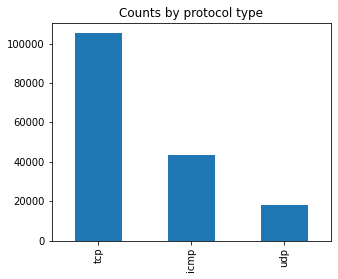

In [12]:
plt.figure(figsize=(5,4))
plt.title("Counts by protocol type")
plot_bar(data, 'protocol_type')

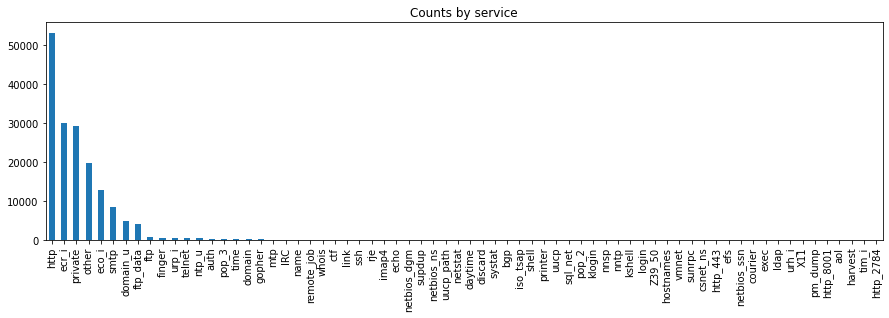

In [13]:
plt.figure(figsize=(15,4))
plt.title("Counts by service")
plot_bar(data, 'service')

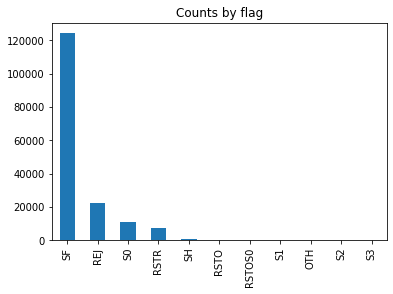

In [14]:
plt.figure(figsize=(6,4))
plt.title("Counts by flag")
plot_bar(data, 'flag')

We can also explore the correlation among different features,

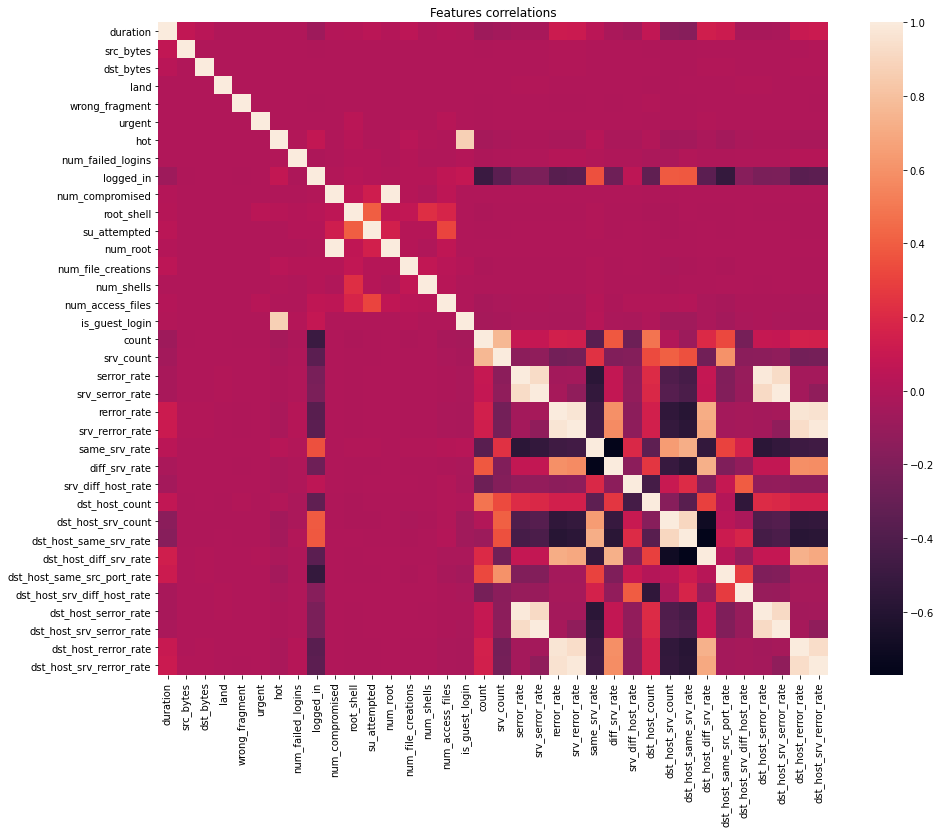

In [15]:
df_corr = data.dropna('columns')
df_corr = df_corr[[col for col in df_corr if df_corr[col].nunique() > 1]]
corr = df_corr.corr()
plt.figure(figsize=(15,12))
sns.heatmap(corr)
plt.title("Features correlations")
plt.show()

As shown in the figure above, the lighter color indicates a higher correlation between two features, and redundant features can be eliminated by higher correlations. Although current advanced machine learning models like deep neural network (DNN) can learn useful features by themselves, it's also very useful to understand the basic theory of feature selections.

## 3 - Ensemble Learning ##

In this section, we will briefly introduce the concept of ensemble learning. In short, Ensemble learning uses multiple learning models to imporve the predictive performance than a single learning model. Common ensemble learning methods are bagging, boosting, and stacking. 

* __Bagging__: Bootstrap Aggregation or Bagging has two distinct features which define its training and prediction. For training it leverages a Bootstrap procedure to separate the training data into different random subsamples, which different iterations of the model use to train on. For prediction, a bagging classifier will use the prediction with the most votes from each model to produce its output and a bagging regression will take an average of all models to produce an output. Bagging is typically applied to high variance models such as Decision Trees and the Random Forest algorithm is a very close variation on bagging.

* __Boosting__: The core definition of boosting is a method that converts weak learners to strong learners, and is typically applied to trees. More explicitly, a boosting algorithm adds iterations of the model sequentially, adjusting the weights of the weak-learners along the way. This reduces bias from the model and typically improves accuracy. Popular boosting algorithms are AdaBoost, Gradient Tree Boosting, and XGBoost, which we’ll focus on here.

* __Stacking__: A Stacking model is a “meta-model” which leverages the outputs from a collection of many, typically significantly different, models as input features. For instance, this allows you to train a K-NN, Linear Regression, and Decision Tree with all of your training data, then take those outputs and merge them with a Logistical Regression. The idea is that this can reduce overfitting and improve accuracy.

In this lab, we foucus on the Boosting methods using XGBoost. XGBoost stands for “Extreme Gradient Boosting” that is based on gradient boosting algorithm. In this Lab, you will learn to how to use XGBoost for attack detection (i.e., classificaiton tasks). More information about XGBoost, please visit visited XGBoost paper [KDD2016](https://www.kdd.org/kdd2016/papers/files/rfp0697-chenAemb.pdf) and its [tutorial](https://xgboost.readthedocs.io/en/latest/tutorials/model.html). 

## 4 - Two-stage Ensemble Learning

The two-stage ensemble learning method is described in the paper [ICDCN18](http://faculty.missouri.edu/calyamp/publications/dolus-cyber-defense-icdcn18.pdf). 

The two-stage ensemble learning has two stages: 
* __Detection Stage__: detect whether a packet is an attack packet or a normal packet. It's a binary classification task ('normal', 'attack')
* __Classification Stage__: classify each attack into these four categories ('dos', 'u2r', 'r2l', 'probe')

As we know, the first stage is a binary classification task and the second stage is multi-classes classifications task. Hence, the task in the first stage is easier than the task in the second stage. Theoretically, we can use fewer features and a simpler model in stage 1 than stage 2. 

####  Why do we use two-stage ensemble learning?

In fact, we can just use one model to classify each packet into 5 classes ('normal', 'dos', 'u2r', 'r2l', 'probe') in one stage. The reason for proposing the two-stage ensemble learning is for computational efficiency. 

In the real-time intrusion detection system (IDS), the packets collectors are distributed around the different hosts, and the collectors need to send the collected packets to the central server to detect attacks. Because the ratio of attack packets is much smaller than the normal packets, most of the time of computation resources and networking transmission resources are wasted in processing "normal packet", which may also cause real attack packets cannot be processed in real-time. 

Our two-stage ensemble learning is to deal with these issues. Because we consider that detection task (binary classification) is simpler than the classification task (multi-classes) classification. For the easier task, we can use less information (or features) to train a model and detect using a fewer amount of dataset; and for the harder task, we can use more information to train and test. 

The whole two-stage ensemble learning can be divided into two phrases,


#### Training phrase
During the trainging phrase, we train two model separately: one is __detection model__ to detect attack or not; one is __classification model__ to classify attacks. In the first task, we need to use as little features and simpler as possible at situations of similar performance. 

#### Testing phrase
During the testing phrase, we always use __detection model__  with less features datasets to detect attack in the beginning. When we detect there is an attack. The server will to request packet client to ask for more features datasets, then we will use __classification model__ to classify attacks. 

In our lab, we only foucs on the machine learning model. And, when to shifing from __deteciton model__ to __classification model__ and when to make a request for more features dataset belongs to system level, which is out of scope of this lab.

Next section, we will implement the two-stage ensemble learning.

## 5 - Two-stage ensemble learning implementaion

In the section, we will implement the two-stage ensemble learning method

### 5.1 - Detection Model

For detection model, we use "label1" (normal, attack) for binary classification,

#### Step 1 - Prepare training and testing datasets

Encoding string features into integer,

In [16]:
for column in data.columns:
    if data[column].dtype == np.object and column != 'label1' and column != 'label2':
        encoded = LabelEncoder()
        
        encoded.fit(data[column])
        data[column] = encoded.transform(data[column])

# Encoding label into integer 
label1_encoded = LabelEncoder()
label1_encoded.fit(data['label1'])
data['label1'] = label1_encoded.transform(data['label1'])

Prepare inputs $X$ and labels $Y$,

In [17]:
# Make our X, which drop label1 and label 2
X = data.drop(['label1', 'label2'], axis=1)
Y = data.label1

# Split our train and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)
        
# We can also rescale some features
scaler = StandardScaler(copy=True, with_mean=True, with_std=True)
X_train[['dst_bytes','src_bytes']] = scaler.fit_transform(X_train[['dst_bytes','src_bytes']])
X_test[['dst_bytes','src_bytes']] = scaler.transform(X_test[['dst_bytes','src_bytes']])

(116734, 41) (50030, 41)
(116734,) (50030,)


#### Step 2 - Select features

At the situation of similar performance, select as fewer features as possible,

In [18]:
selected_features = ['protocol_type', 'src_bytes']

#### Step 3 - Model training

In [19]:
# define our model
detector = XGBClassifier(max_depth=3, n_estimators=10, random_state=42, verbosity=1)

# train the model
detector.fit(X_train[selected_features], y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=10, n_jobs=0, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=1)

#### Step 4 - Model testing 

In [20]:
# test the model
print("The trianing accuracy: ", detector.score(X_train[selected_features], y_train))
print("The testing accuracy: ",detector.score(X_test[selected_features],y_test))

The trianing accuracy:  0.9623845666215498
The testing accuracy:  0.9616630021986808


As shown above, we can achieve $96\%$ accuracy in test datasets with only 2 features that effectively saves computational and networking resources. 

### 5.2 - Classification Model

For classification model, our task is to classify each attack into four categories ('dos', 'u2r', 'r2l', 'probe'). Hence, we just need to consider the attack dataset, Hence, we need to drop "normal" labels.

#### Step 1 - Prepare training and testing datasets

We need to drop the rows with label "normal". 

In [21]:
data_cls = data[data.label2 != 'normal']
data_cls.label2.value_counts()

dos      41102
probe    41102
r2l       1126
u2r         52
Name: label2, dtype: int64

Encoding label into integer

In [22]:
label2_encoded = LabelEncoder()
label2_encoded.fit(data_cls['label2'])
data_cls['label2'] = label2_encoded.transform(data_cls['label2'])

Prepare inputs $X$ and labels $Y$,

In [23]:
# Make our X, which drop label1 and label 2
X = data_cls.drop(['label1', 'label2'], axis=1)
Y = data_cls.label2

# Split our train and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)
        
# We can also rescale some features
scaler = StandardScaler(copy=True, with_mean=True, with_std=True)
X_train[['dst_bytes','src_bytes']] = scaler.fit_transform(X_train[['dst_bytes','src_bytes']])
X_test[['dst_bytes','src_bytes']] = scaler.transform(X_test[['dst_bytes','src_bytes']])

(58367, 41) (25015, 41)
(58367,) (25015,)


#### Step 2 - Select features

We can just use same features as detector model to see the performance

In [24]:
selected_features = ['protocol_type', 'src_bytes']

#### Step 3 - Model training

In [25]:
# define our model
classifier = XGBClassifier(max_depth=3, n_estimators=10, random_state=42, verbosity=1)

# train the model
classifier.fit(X_train[selected_features], y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=10, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', random_state=42, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=1)

#### Step 4 - Model testing

In [26]:
# test the model
print("The training accuracy: ", classifier.score(X_train[selected_features], y_train))
print("The testing accuracy: ",classifier.score(X_test[selected_features], y_test))

The trianing accuracy:  0.8620453338359004
The testing accuracy:  0.8618029182490505


We can also print the confusion matrix to check performance for each class,

In [27]:
y_pred = classifier.predict(X_test[selected_features])
print("Confusion matrix:")
print(confusion_matrix(y_test, y_pred))

Confusion matrix:
[[ 8861  3415     0     0]
 [    0 12376     0     0]
 [    0    33   314     0]
 [    0     6     3     7]]


### 5.3 - Conclusion

Hence, if we use same features in detector and classification model, the detector model (simple model) works better than classification model. If we want to imporve the performance of classification model, we need to add more features or increase the complexity of the model. You need to implement this in your homework. 

## Questions

1. Explain the main purposes of two-stages ensemble learning?
2. As we mention in this lab, the original $10\%$ dataset is not balanced well. Can you explain the effect of imbalanced datasets? and how to deal with imbalanced datasets?
3. Take research about XGBoost, can you briefly introduce what is XGBoost and differences between XGBoost and GBDT?
4. Using lab results in section 5 as our baseline, can you improve the testing accuracy performance of the classification model by adding more features or complexity of ensemble models or any other methods. But, the model should be restricted in XGBoost. Please submit your executable jupyter notebook file (*.ipyn) with output.